In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

from keras.preprocessing.sequence import pad_sequences #padding
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split #train/test splitting

#model building
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

#data = pd.read_csv("ner_dataset.csv", encoding="latin1")

url = "https://raw.githubusercontent.com/deanhoperobertson/Masters-/master/Thesis/ner_dataset.csv"
data = pd.read_csv(url)

Using TensorFlow backend.


In [2]:
data = data.fillna(method="ffill")
data.tail(10)

,Sentence #,Word,POS,Tag
1048565,Sentence: 47958,impact,NN,O
1048566,Sentence: 47958,.,.,O
1048567,Sentence: 47959,Indian,JJ,B-gpe
1048568,Sentence: 47959,forces,NNS,O
1048569,Sentence: 47959,said,VBD,O
1048570,Sentence: 47959,they,PRP,O
1048571,Sentence: 47959,responded,VBD,O
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O
1048574,Sentence: 47959,attack,NN,O


In [0]:
words = list(set(data["Word"].values))
words.append("ENDPAD")

In [4]:
#number of words
n_words = len(words); n_words

35179

In [5]:
#extract tags
tags = list(set(data["Tag"].values))
n_tags = len(tags); n_tags

17

So we have 47959 sentences containing 35178 different words with 17 different tags. 

In [0]:
#define a class to retrieve sentences and labels

class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None
        


In [0]:
getter = SentenceGetter(data)

In [0]:
sent = getter.get_next()

In [9]:
print(sent)

[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


In [0]:
#retrieve all the sentences
sentences = getter.sentences

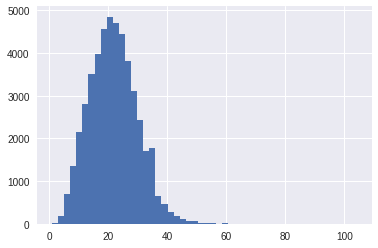

In [11]:
## plot the seneteces
#plt.style.use("ggplot")

plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [0]:
max_len = 50

#creates a dictionary of words and tags
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [13]:
word2idx["Obama"]

31672

In [14]:
tag2idx["B-geo"]

7

In [15]:
##pad sentences with zeros
X = [[word2idx[w[0]] for w in s] for s in sentences]

X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_words - 1)

X[1]

array([28437,  4045, 27045, 11077, 25326, 18576,  5167,  1381, 18576,
        1028, 29871,  4123, 16351, 11362, 27431,  5976, 30762, 19737,
        9795, 31022, 27185, 19311,  4511, 28689,   364, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178], dtype=int32)

In [16]:
#need to also hot code the the tag sequences
y = [[tag2idx[w[2]] for w in s] for s in sentences]

y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

y[1]

array([1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 8, 6, 6, 6, 5, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6], dtype=int32)

In [0]:
#change the tags to categorical
y = [to_categorical(i, num_classes=n_tags) for i in y]


In [0]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)

In [0]:
#model architecture

input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words, output_dim=50, input_length=max_len)(input)
model = Dropout(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)  # softmax output layer

In [0]:
model = Model(input, out)

In [21]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 50)            1758950   
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 200)           120800    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 50, 17)            3417      
Total params: 1,883,167
Trainable params: 1,883,167
Non-trainable params: 0
_________________________________________________________________


In [22]:
history = model.fit(X_tr, np.array(y_tr), batch_size=32, epochs=5, validation_split=0.1, verbose=1)
hist = pd.DataFrame(history.history)

Train on 38846 samples, validate on 4317 samples
Epoch 1/5
38846/38846 [==============================] - 355s 9ms/step - loss: 0.1404 - acc: 0.9644 - val_loss: 0.0619 - val_acc: 0.9821
Epoch 2/5
38846/38846 [==============================] - 354s 9ms/step - loss: 0.0548 - acc: 0.9838 - val_loss: 0.0505 - val_acc: 0.9849
Epoch 3/5
38846/38846 [==============================] - 355s 9ms/step - loss: 0.0457 - acc: 0.9865 - val_loss: 0.0465 - val_acc: 0.9861
Epoch 4/5
38846/38846 [==============================] - 358s 9ms/step - loss: 0.0413 - acc: 0.9878 - val_loss: 0.0447 - val_acc: 0.9865
Epoch 5/5
38846/38846 [==============================] - 358s 9ms/step - loss: 0.0386 - acc: 0.9886 - val_loss: 0.0434 - val_acc: 0.9867


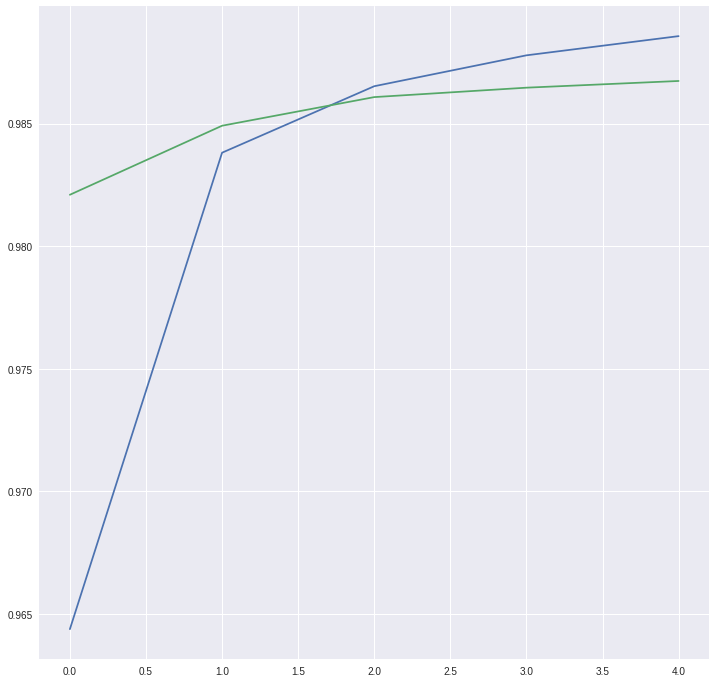

In [23]:
#plot performance
plt.figure(figsize=(12,12))
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])
plt.show()

In [24]:
i = 2318
p = model.predict(np.array([X_te[i]]))
p = np.argmax(p, axis=-1)
print("{:15} ({:5}): {}".format("Word", "True", "Pred"))
for w, pred in zip(X_te[i], p[0]):
    print("{:15}: {}".format(words[w], tags[pred]))

Word            (True ): Pred
He             : O
called         : O
on             : O
supporters     : O
to             : O
end            : O
their          : O
protests       : O
and            : O
begin          : O
what           : O
he             : O
calls          : O
a              : O
new            : O
political      : O
struggle       : O
.              : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
